<center>

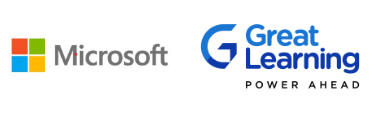
</center>

<center>
<h1><b>Text-to-Text tasks with Azure Open AI</b>
</center>

# Objectives

- Illustrate prompt engineering for text-to-text tasks using Azure Open AI.
- Build and evaluate LLMs for text-to-text tasks using appropriate metrics (e.g., ROUGE score and BERTscore).

# Text $→$ Text generation

While evaluation of text-to-text tasks requires new evaluation metrics, the overall process of creating a generative AI solution remains the same as that we saw for classification tasks.

Specifically, solutions for text $\rightarrow$ text tasks can be built using LLM machinery using the following steps.

>*Step 1:* Frame the task as a combination of objective and metric.
>
>*Step 2:* Assemble data (i.e., examples and gold examples).
>
>*Step 3:* Design prompts using best practises such as few-shot, CoT, ReAct and evaluate them on gold examples.

# Setup

This notebook needs to be executed with a GPU runtime since we load a transformer model to disk and use it to evaluate text-to-text tasks. Transformer models benefit from parallel execution offered by a GPU runtime and can have a significant impact on execution times (for e.g., code in this notebook runs up to 4 times faster witha GPU). Follow the screenshots below to create a GPU runtime on a Colab instance.

You should now see the T4 GPU mentioned in the runtime logo (screenshot below).

## Installation

In [2]:
!pip install openai tiktoken datasets \
             evaluate rouge_score bert_score --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 96.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 98.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 31.9 MB/s

## Imports

In [3]:
import openai
import json
import tiktoken
import evaluate

import numpy as np
import pandas as pd

from datasets import load_dataset
from collections import Counter
from tqdm import tqdm

from sklearn.model_selection import train_test_split

## Authentication

In [6]:
with open('config-template.json', 'r') as az_creds:
    data = az_creds.read()

In [7]:
data

'{"AZURE_OPENAI_KEY": "1dd305f495014c0694411d4d3826c42b", "AZURE_OPENAI_ENDPOINT": "https://azure-open-ai777.openai.azure.com/", "AZURE_OPENAI_APITYPE": "azure", "AZURE_OPENAI_APIVERSION": "2023-07-01-preview", "CHATGPT_MODEL":"gpt-35-turbo"}'

In [8]:
creds = json.loads(data)

In [9]:
openai.api_key = creds["AZURE_OPENAI_KEY"]
openai.api_base = creds["AZURE_OPENAI_ENDPOINT"]
openai.api_type = creds["AZURE_OPENAI_APITYPE"]
openai.api_version = creds["AZURE_OPENAI_APIVERSION"]

In [10]:
chat_model_id = creds["CHATGPT_MODEL"]

In [11]:
chat_model_id

'gpt-35-turbo'

## Utilities

Token counter to keep track of the completion window available in the prompt.

In [12]:
def num_tokens_from_messages(messages):

    """
    Return the number of tokens used by a list of messages.
    Adapted from the Open AI cookbook token counter
    """

    encoding = tiktoken.encoding_for_model("mls")

    # Each message is sandwiched with <|start|>role and <|end|>
    # Hence, messages look like: <|start|>system or user or assistant{message}<|end|>

    tokens_per_message = 3 # token1:<|start|>, token2:system(or user or assistant), token3:<|end|>

    num_tokens = 0

    for message in messages:
        num_tokens += tokens_per_message
        for key, value in message.items():
            num_tokens += len(encoding.encode(value))

    num_tokens += 3  # every reply is primed with <|start|>assistant<|message|>

    return num_tokens

## Task 1: Summarization

### Step 1: Define objectives and metrics

There are two methods to summarize input text:
- Abstractive (output: a gist of the input).
- Extractive (output: a selection of key sentences from the input).

Customer Review:
I recently signed up for an ML pgrogram and, to my disappointment, I encountered significant setbacks due to technical glitches and unresponsive academic support. My overall experience has been subpar.

Right from the beginning, I faced several technical issues that hampered my learning process. The platform's interface often froze, disrupting the flow of my sessions and causing frustration. Moreover, the video playback was inconsistent, making it challenging to follow the lessons effectively.

Abstractive Summary:
Major issues,  technical issues and unsatisfactory support

Extractive Summary:
I recently signed up for an ML pgrogram and, to my disappointment, I encountered significant setbacks due to technical glitches and unresponsive academic support.

The objective in abstractive summarization is to generate a clear summary of the input text, while that of extractive summarization is to generate a selection of appropriate sentences that summarize the input text.

#### Recall-Oriented Understudy for Gisting Evaluation (ROUGE)

ROUGE takes a exact match approach to compare the prediction from the model with the human reference summary by relying on matches of n-grams between the two (depicted in the figure below).

In [13]:
ai_generated_summary = "Major issues, technical issues and unsatisfactory support"
human_generated_summary = "Significant technical issues and  support were prominent factors affecting the experience."

In [14]:
r_lcs, p_lcs = 5/12, 5/7
(2 * r_lcs * p_lcs)/(r_lcs + p_lcs) # rouge-L

0.5263157894736842

#### BERTScore

BERTScore is ideal in situations where abstractive summarization is the objective (as is in this case). To illustrate the computation of the BERTScore, consider the following two summary outputs (one from a generative AI model and another from a human).

In [15]:
ai_generated_summary =  "Key problems encompassed technical issues and inadequate support."
human_generated_summary =   "Prominent challenges and insufficient help, significantly impacting the experience."

In [16]:
print(ai_generated_summary)
print(human_generated_summary)

Key problems encompassed technical issues and inadequate support.
Prominent challenges and insufficient help, significantly impacting the experience.


In [17]:
bert_scorer = evaluate.load("bertscore")

In [18]:
bert_scorer.compute(
    predictions=[ai_generated_summary],
    references=[human_generated_summary],
    lang="en",
    rescale_with_baseline=True
)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'precision': [0.4012412428855896],
 'recall': [0.3585689663887024],
 'f1': [0.3808262050151825],
 'hashcode': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.35.0)-rescaled'}

#### LLM rating LLM output

Another commonly used method to automate evaluations is to use a different model (e.g., GPT-4, LLaMA2) to evaluate the output from the model used to execute the text-to-text task (in this case GPT-3.5). The figure below illustrates the steps involved for the case where a summary is generated for the input text.

In [19]:
rater_system_message = """
You are tasked with rating AI-generated summaries of customer reviews.
You will be presented a review and an AI generated summary of the review as the input.
In the input, the review will begin with ###Review while the AI generated summary will begin with ###Summary.

Instructions:
1. Carefully observe the review and its AI-generated summary presented in the input
2. Rate the quality of the summary generated by the AI system on a scale of 1 to 5, 1 being low quality and 5 being high quality.
Note that the AI system was asked to generate a concise summary reflecting the most important points mentioned in the review.
In your rating, focus your assessment only on whether the summary was an accurate, concise reflection of key points in the review.

Please do not explain your rating, the output should only be the rating between 1 to 5.
"""

In [20]:
rater_user_message_template = """
###Review
{review}

###Summary
{summary}
"""

In [21]:
customer_review = """
I signed up for an ML pgrogram and, to my disappointment, I encountered significant setbacks due to technical glitches and unresponsive academic support. My overall experience has been subpar.

Right from the beginning, I faced several technical issues that hampered my learning process. The platform's interface often froze, disrupting the flow of my sessions and causing frustration. Moreover, the video playback was inconsistent, making it challenging to follow the lessons effectively.
"""

In [22]:
ai_generated_summary = "Key problems encompassed technical issues and inadequate support."

In [23]:
prompt = [
    {
        'role': 'system',
        'content': rater_system_message
    },
    {
        'role': 'user',
        'content': rater_user_message_template.format(
            review=customer_review,
            summary=ai_generated_summary
        )
    }
]

In [24]:
response = openai.ChatCompletion.create(
    deployment_id=chat_model_id,
    messages=prompt,
    temperature=0
)

In [25]:
response['choices'][0]['message']['content']

'4. The summary accurately reflects the key points mentioned in the review.'

### Step 2: Assemble data

With the objective and metrics out of the way, let us now assemble the data for this use case. As in the case text classification, a dataset is a task-specific subset of a corpus.

In [26]:
dataset = load_dataset("knkarthick/dialogsum")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [27]:
len(dataset['train'])

12460

In [28]:
dialogue_summary_train_df = dataset['train'].to_pandas()

In [29]:
dialogue_summary_train_df.sample(5)

,id,dialogue,summary,topic
12160,train_12160,"#Person1#: Good morning, sir. Are you checking...",#Person1# is helping Mr. Smith check out. Mr. ...,check out
6275,train_6275,"#Person1#: May I see a hat , please? \n#Person...",#Person2# measures #Person1# and helps #Person...,hat
7217,train_7217,"#Person1#: Excuse me, are you Sara Wilson?\n#P...",Tom helps Sara Wilson with her heavy bag.,help carry bags
128,train_128,"#Person1#: Oh, I am starving.\n#Person2#: Me t...",#Person2# suggests they eat out. But #Person1#...,meal
7792,train_7792,#Person1#: Please help yourself to whatever yo...,#Person1# asks #Person2# to try the hot dish a...,have a meal


In [30]:
dialogue_summary_train_df.topic.value_counts()

shopping                 174
job interview            161
daily casual talk        125
phone call                89
order food                79
                        ... 
eat ice creams             1
marriage predicaments      1
ways of commuting          1
food comment               1
baggage pack               1
Name: topic, Length: 7434, dtype: int64

In [31]:
dialogue_summary_examples_df, dialogue_summary_gold_examples_df = train_test_split(
    dialogue_summary_train_df, #<- the full dataset
    test_size=0.2, #<- 20% random sample selected for gold examples
    random_state=42 #<- ensures that the splits are the same for every session
)

Let us sample 50 gold examples that will be held fixed for prompt evaluation (as depicted in the figure above). Note that we are doing this only only for illustration. In practise, large number of gold examples facilitate robust estimates of model performance.

In [32]:
columns_to_select = ['dialogue', 'summary']

gold_examples = (
    dialogue_summary_gold_examples_df.loc[:, columns_to_select]
                                     .sample(50, random_state=42) # ensures that the gold examples are the same between sessions
                                     .to_json(orient='records')
)

In [33]:
len(json.loads(gold_examples))

50

In [35]:
json.loads(gold_examples)[1]

{'dialogue': "#Person1#: Mom, did you feel the earthquake this afternoon?\n#Person2#: Oh, that scared me.\n#Person1#: The breaking news just reported some houses were destroyed by the earthquake.\n#Person2#: Oh, dear! How ruthless!\n#Person1#: Do you think we can donate some clothes and food for the victims?\n#Person2#: Why not? That's a good idea to help them.",
 'summary': '#Person1# and Mom decide to donate clothes and food to victims from the earthquake.'}

### Step 3: Derive prompt

In [36]:
system_message = """
Summarize the dialogue mentioned in the user input. Be specific and concise in your summary.
"""

With the system message in place, we can now assemble a few-shot prompt. Notice how the construction of the few-shot prompt mirrors the function we created for classificiation tasks.

In [46]:
def create_few_shot_prompt(system_message, examples_df, n=8):

    """
    Return a prompt message in the format expected by the Open AI API.
    n examples (default 8) are selected randomly from training data to form the
    few-shot prompt.
    We then loop through each example and parse the dialogue as the user message
    and the summary as the assistant message.

    Args:
        system_message (str): system message with instructions for summarization
        examples_df (DataFrame): A DataFrame with examples (conversation + summary)
        n (int): number of examples of each class to be selected

    Output:
        few_shot_prompt (List): A list of dictionaries in the Open AI prompt format
    """

    few_shot_prompt = [{'role':'system', 'content': system_message}]
    columns_to_select = ['dialogue', 'summary']

    examples = (
        examples_df.loc[:, columns_to_select]
                   .sample(n)
                   .to_json(orient='records')
    )

    for example in json.loads(examples):
        user_input_example = example['dialogue']
        assistant_output_example = example['summary']

        few_shot_prompt.append(
            {
                'role': 'user',
                'content': user_input_example
            }
        )

        few_shot_prompt.append(
            {
                'role': 'assistant',
                'content': assistant_output_example
            }
        )

    return few_shot_prompt

Each time this function is executed, a new set of examples is sampled and a prompt is created.

In [47]:
few_shot_prompt = create_few_shot_prompt(
    system_message,
    dialogue_summary_examples_df
)

In [54]:
import time

While we now have a few-shot prompt assembled, we will still need to ascertain that there is little variability in the performance of this prompt (i.e., the BERTScores or ROUGE-L have less variance).

In [60]:
def evaluate_prompt(prompt, gold_examples, scorer, bert_score=False):

    """
    Return the ROUGE score or BERTScore for predictions on gold examples
    For each example we make a prediction using the prompt.
    Gold summaries and the AI generated summaries are aggregated into lists.
    These lists are used by the corresponding scorers to compute metrics.
    Since BERTScore is computed for each candidate-reference pair, we take the
    average F1 score across the gold examples.

    Args:
        prompt (List): list of messages in the Open AI prompt format
        gold_examples (str): JSON string with list of gold examples
        scorer (function): Scorer function used to compute the ROUGE score or the
                           BERTScore
        bert_score (boolean): A flag variable that indicates if BERTScore should
                              be used as the metric.

    Output:
        score (float): BERTScore or ROUGE score computed by comparing model predictions
                       with ground truth
    """

    model_predictions, ground_truths = [], []

    for example in json.loads(gold_examples):
        time.sleep(11)
        gold_dialogue = example['dialogue']
        user_input = [
            {
                'role':'user',
                'content': gold_dialogue
            }
        ]

        try:
            response = openai.ChatCompletion.create(
                deployment_id=chat_model_id,
                messages=prompt+user_input,
                temperature=0
            )

            prediction = response['choices'][0]['message']['content']
            model_predictions.append(prediction)
            ground_truths.append(example['summary'])

        except Exception as e:
            print(e) # A better error handling mechanism could be implemented
            continue

    if bert_score:
        score = scorer.compute(
            predictions=model_predictions,
            references=ground_truths,
            lang="en",
            rescale_with_baseline=True
        )

        return sum(score['f1'])/len(score['f1'])
    else:
        return scorer.compute(
            predictions=model_predictions,
            references=ground_truths
        )

In [56]:
rouge_scorer = evaluate.load("rouge")
bert_scorer = evaluate.load("bertscore")

In [57]:
evaluate_prompt(
    few_shot_prompt,
    gold_examples,
    rouge_scorer
)

The response was filtered due to the prompt triggering Azure OpenAI’s content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766
Requests to the ChatCompletions_Create Operation under Azure OpenAI API version 2023-07-01-preview have exceeded call rate limit of your current OpenAI S0 pricing tier. Please retry after 10 seconds. Please go here: https://aka.ms/oai/quotaincrease if you would like to further increase the default rate limit.
Requests to the ChatCompletions_Create Operation under Azure OpenAI API version 2023-07-01-preview have exceeded call rate limit of your current OpenAI S0 pricing tier. Please retry after 10 seconds. Please go here: https://aka.ms/oai/quotaincrease if you would like to further increase the default rate limit.
Requests to the ChatCompletions_Create Operation under Azure OpenAI API version 2023-07-01-preview have exceeded c

{'rouge1': 0.3692763827678065,
 'rouge2': 0.11386203795106703,
 'rougeL': 0.28336712861471636,
 'rougeLsum': 0.28489375311961623}

Note that the metric we need is [$\text{ROUGE}_L$](https://huggingface.co/spaces/evaluate-metric/rouge) that computes the ROUGE score for the longest common subsequence.

In [61]:
evaluate_prompt(
    few_shot_prompt,
    gold_examples,
    bert_scorer,
    bert_score=True
)

The response was filtered due to the prompt triggering Azure OpenAI’s content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766


0.4991526986871447

Since this is abstractive summarization, we focus on BERTScore as the evaluation metric. In this example, we get a BERTScore of around 0.49 with a set of 8 examples chosen at random from the training data to form the few-shot prompt.

